<a href="https://colab.research.google.com/github/ajuan8716/datasciencecoursera/blob/master/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER Model

In this notebook, we train a

https://medium.com/@palashm0002/simple-use-case-building-a-named-entity-recognition-system-with-python-7e87f5fd5908

## Steps in the notebook


1.   Load the
2.   **Pre-process the dataset**
3.   

## Setting the environment

Mount the Google Drive to access your files.

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pdfminer.six
!pip install docx2txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3959 sha256=46c4ccff2edf9326a538d53587ea559c41aa9ab00bd614a8b1bb000a1b4e6d56
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt


In [2]:
# Importing essential libraries and functions
import spacy
nlp = spacy.load('en_core_web_sm')

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
from collections import Counter
from collections import defaultdict
import torch
import docx2txt

from transformers import pipeline, AutoTokenizer, AutoModel
from subprocess import list2cmdline
from pdfminer.high_level import extract_text
from sklearn.metrics.pairwise import cosine_similarity
from spacy.matcher import Matcher
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split



In [3]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading and exploring datasets

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Resume.csv to Resume.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving jz_skill_patterns.jsonl to jz_skill_patterns.jsonl


In [6]:
# Importing dataset

text = pd.read_csv("Resume.csv")


In [7]:
# Dataset exploration

text.shape

(2484, 4)

In [8]:
text.head(5)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [9]:
data = []
with open("jz_skill_patterns.jsonl", 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Create a pandas DataFrame from the list of dictionaries
text2 = pd.DataFrame(data)

In [10]:
text2.shape

(2129, 2)

In [11]:
text2.head(5)

,label,pattern
0,SKILL,[{'TEXT': '.NET'}]
1,SKILL,"[{'LOWER': ''}, {'LOWER': 'net'}]"
2,SKILL,[{'LOWER': '1password'}]
3,SKILL,[{'TEXT': '3D'}]
4,SKILL,"[{'LOWER': '3d'}, {'LOWER': 'reconstruction'}]"


In [12]:
text2.tail(5)

,label,pattern
2124,SKILL,[{'LOWER': 'zeplin'}]
2125,SKILL,[{'LOWER': 'zepto'}]
2126,SKILL,[{'LOWER': 'zeromq'}]
2127,SKILL,"[{'LOWER': 'zoho'}, {'LOWER': 'crm'}]"
2128,SKILL,[{'LOWER': 'zookeeper'}]


## Defining NER model for entity identification

Parts of this model were used taking into account information from: https://stackoverflow.com/questions/72986264/company-name-extraction-with-bert-base-ner-easy-way-to-know-which-words-relate

In [14]:
start = time.time()
model_checkpoint = "xlm-roberta-large-finetuned-conll03-english"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

def text_extraction(file):
    try:
        df = pd.read_csv(file)
        text = ' '.join(df.astype(str).values.flatten())
        return text.replace('\t', ' ')
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Replace newlines and multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def extract_organizations(text):
    # Use regex to find potential company names
    company_patterns = [
        r'(?:^|\s)(?:at|for|with)\s+((?:[A-Z][a-z]+\s?)+(?:Inc\.?|LLC|Ltd\.?|Corporation|Corp\.?|Company|Co\.?)?)',
        r'(?:^|\s)((?:[A-Z][a-z]+\s?)+(?:Inc\.?|LLC|Ltd\.?|Corporation|Corp\.?|Company|Co\.?))',
        r'Company Name\s*[－-]\s*([^,]+)'
    ]

    potential_orgs = []
    for pattern in company_patterns:
        potential_orgs.extend(re.findall(pattern, text))

    # Use the transformer model for additional entity recognition
    classifier_results = token_classifier(text)
    model_orgs = [item["word"] for item in classifier_results if item["entity_group"] == "ORG"]

    # Combine results
    all_orgs = list(set(potential_orgs + model_orgs))

    return post_process_orgs(all_orgs)

def post_process_orgs(orgs):
    # Remove duplicates and sort
    orgs = sorted(set(orgs))
    # Remove generic terms often misclassified as organizations
    blacklist = {'hr', 'human resources', 'payroll', 'assistant', 'intern', 'coordinator', 'manager', 'company name'}
    orgs = [org for org in orgs if org.lower() not in blacklist]
    # Remove entries that are likely job titles
    orgs = [org for org in orgs if not any(title in org.lower() for title in ['assistant', 'manager', 'coordinator', 'director', 'specialist'])]
    return orgs

def analyze_resume(file):
    extracted_text = text_extraction(file)
    if extracted_text is None:
        return

    preprocessed_text = preprocess_text(extracted_text)
    organizations = extract_organizations(preprocessed_text)

    print("Extracted Organizations:")
    for i, org in enumerate(organizations, 1):
        print(f"{i}. {org}")

    print(f"\nTotal unique organizations extracted: {len(organizations)}")

    # Find most common organizations
    org_counts = Counter(organizations)
    print("\nMost common organizations:")
    for org, count in org_counts.most_common(5):
        print(f"  {org}: {count}")

csv_file = "Resume.csv"
analyze_resume(csv_file)

end = time.time()
print(f"\nExecution time: {round((end - start), 2)} seconds")

Some weights of the model checkpoint at xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more 

Streaming output truncated to the last 5000 lines.
5411. Life Publicity Chair
5412. Life Sciences Co
5413. Life Skills Co
5414. Life Style Ltd.
5415. Lifeguard Company
5416. Lifestyle Ltd.
5417. Lifetime Premier Club Studio Six Larry North Dallas Co
5418. Light Technologies
5419. Lighting Designer Company
5420. Lighting Specifiers 
5421. Lilly
5422. Limestone Co
5423. Limited Liability Corporation
5424. Linac Co
5425. Lincoln Co
5426. Lincoln County School 
5427. Linda Gaunt Co
5428. Lindenwold 
5429. Lindsey Wilson Co
5430. Line 
5431. Line Chef Company
5432. Line Co
5433. Line Cook Company
5434. Line Crews Safety Gear 
5435. Line Delivery 
5436. Line Maintenance 
5437. Line Prep Co
5438. Linear Multivariable Co
5439. Lineham Creek Encana Corporation
5440. Lines 
5441. Linux 
5442. Linux Graduate Certificate 
5443. Linux System Administrator Company
5444. Linux System Engineer Company
5445. Lipitor 
5446. Lipitor Convention Co
5447. List Co
5448. List Corp
5449. List Lonestar Co
5450.

## Defining NER2 for skills identification


In [15]:
start = time.time()
model_checkpoint = "xlm-roberta-large-finetuned-conll03-english"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

def text_extraction(file):
    """
    To extract texts from pdf, word, or csv files
    """
    if file.endswith(".pdf"):
        return extract_text(file)
    elif file.endswith(".docx"):
        resume_text = docx2txt.process(file)
        if resume_text:
            return resume_text.replace('\t', ' ')
        return None
    elif file.endswith(".csv"):
        try:
            df = pd.read_csv(file)
            text = ' '.join(df.astype(str).values.flatten())
            return text.replace('\t', ' ')
        except Exception as e:
            print(f"Error reading file: {e}")
            return None
    else:
        return None

def load_custom_entities(jsonl_file):
    custom_entities = []
    with open(jsonl_file, 'r') as file:
        for line in file:
            data = json.loads(line)
            pattern = data.get('pattern', [])
            skill = " ".join([item.get('LOWER', '') for item in pattern]).strip()
            if skill:
                custom_entities.append(skill)
    return custom_entities

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def find_skills(text, skills):
    found_skills = []
    for skill in skills:
        if skill in text:
            found_skills.append(skill)
    return found_skills

def custom_entity_extraction(file, custom_entities):
    extracted_text = text_extraction(file)
    if not extracted_text:
        print("No text extracted from the file.")
        return

    preprocessed_text = preprocess_text(extracted_text)

    # Find skills in the preprocessed text
    found_skills = find_skills(preprocessed_text, custom_entities)

    # Use the transformer model for additional entity recognition
    classifier_results = token_classifier(extracted_text)

    # Combine results
    all_entities = set(found_skills + [item['word'].lower() for item in classifier_results if item['word'].lower() in custom_entities])

    # Sort entities
    sorted_entities = sorted(all_entities, key=lambda x: (-len(x), x))

    print("Extracted Skills:")
    for skill in sorted_entities:
        print(f"  {skill}")

    print(f"\nTotal unique skills extracted: {len(sorted_entities)}")

    # Find most common skills
    single_word_skills = [skill for skill in sorted_entities if ' ' not in skill]
    most_common = Counter(single_word_skills).most_common(5)
    print("\nMost common single-word skills:")
    for skill, count in most_common:
        print(f"  {skill}: {count}")

# Load custom entities from JSONL file
jsonl_file = "jz_skill_patterns.jsonl"
custom_entities = load_custom_entities(jsonl_file)

# Apply model
custom_entity_extraction("Resume.csv", custom_entities)

end = time.time()
print(f"\nExecution time: {round((end - start), 2)} seconds")

Some weights of the model checkpoint at xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more 

Extracted Skills:
  computer aided software engineering
  distributed computing environment
  customer relationship management
  field programmable gate array
  optical character recognition
  electronic data interchange
  natural language processing
  object oriented programming
  data manipulation language
  document management system
  intrusion detection system
  operational transformation
  telecommunications service
  architectural engineering
  artificial neural network
  digital signal processing
  discrete event simulation
  environmental engineering
  exploratory data analysis
  manufacturing engineering
  agile project management
  agricultural engineering
  construction engineering
  content delivery network
  geotechnical engineering
  graphical user interface
  synthetic aperture radar
  artificial intelligence
  business administration
  central processing unit
  communications protocol
  decision support system
  distributed file system
  industrial organization
  pulp 

## Preparing the embedding

Creating word embeddings from two models

In [16]:
# Embedding for entity model

start = time.time()
model_name = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def text_extraction(file):
    try:
        df = pd.read_csv(file)
        text = ' '.join(df.astype(str).values.flatten())
        return text.replace('\t', ' ')
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

def preprocess_text(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

def extract_potential_orgs(text):
    company_patterns = [
        r'(?:^|\s)(?:at|for|with)\s+((?:[A-Z][a-z]+\s?)+(?:Inc\.?|LLC|Ltd\.?|Corporation|Corp\.?)?)',
        r'(?:^|\s)((?:[A-Z][a-z]+\s?)+(?:Inc\.?|LLC|Ltd\.?|Corporation|Corp\.?))',
        r'Company Name\s*[－-]\s*([^,]+)'
    ]

    potential_orgs = []
    for pattern in company_patterns:
        potential_orgs.extend(re.findall(pattern, text))

    return list(set(potential_orgs))

def is_likely_org(org_name, org_embedding, known_org_embeddings, threshold=0.8):
    similarities = cosine_similarity([org_embedding], known_org_embeddings)[0]
    return np.max(similarities) > threshold

#expanded blacklist from previous outcome

def post_process_orgs(orgs):
    orgs = sorted(set(orgs))
    blacklist = {'hr', 'human resources', 'payroll', 'assistant', 'intern', 'coordinator', 'manager', 'company name', 'Zip Code Phone Number Email Address Date Employer Co', 's', 'io', 'wide', 'Youth', 'You',
                 'Year Achievement Award Navy Unit Commendation Navy Meritorious Unit Co', 'Work History Company Name Certifications Inorganic Chemistry Organic Chemistry Materials Science Nanomaterials Unit Operations Fluid Mechanics Thermodynamics Transport Phenomenon Process Co',
                 'Success'
                 }
    orgs = [org for org in orgs if org.lower() not in blacklist]
    orgs = [org for org in orgs if not any(title in org.lower() for title in ['assistant', 'manager', 'coordinator', 'director', 'specialist'])]
    return orgs

def analyze_resume(file):
    extracted_text = text_extraction(file)
    if extracted_text is None:
        return

    preprocessed_text = preprocess_text(extracted_text)
    potential_orgs = extract_potential_orgs(preprocessed_text)

    # Get embeddings for known organizations (you can expand this list)
    known_orgs = ["Google", "Microsoft", "Apple", "Amazon", "Facebook", "IBM", "Intel"]
    known_org_embeddings = [get_embedding(org) for org in known_orgs]

    confirmed_orgs = []
    for org in potential_orgs:
        org_embedding = get_embedding(org)
        if is_likely_org(org, org_embedding, known_org_embeddings):
            confirmed_orgs.append(org)

    confirmed_orgs = post_process_orgs(confirmed_orgs)

    print("Extracted Organizations:")
    for i, org in enumerate(confirmed_orgs, 1):
        print(f"{i}. {org}")

    print(f"\nTotal unique organizations extracted: {len(confirmed_orgs)}")

csv_file = "Resume.csv"
analyze_resume(csv_file)

end = time.time()
print(f"\nExecution time: {round((end - start), 2)} seconds")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Extracted Organizations:
1. Abbott 
2. Abbott Finance 
3. Abbott Laboratories
4. Abekas
5. Abn Amro Bank 
6. Abu Dhabi Company 
7. Abu Dhabi Marine Operating Company 
8. Academic 
9. Academic Achievement
10. Academic Excellence
11. Academic Honors
12. Academic Progress Recognition 
13. Academic Web Services 
14. Academy 
15. Accenture 
16. Accenture Technologies
17. Accenture Worked 
18. Accepts 
19. Access Services
20. Accomplishments Hexcel Corporation
21. Accomplishments Inc
22. Accomplishments Quality Control Inc
23. Accord
24. Account 
25. Account Executives 
26. Account Receivable 
27. Accountant 
28. Accounting
29. Accounting 
30. Accounting Department 
31. Accounting Dept
32. Accounting Histories Record All Monetary Transactions Produce Weekly
33. Accounting Skills 
34. Accounting Skills Corp
35. Accounts 
36. Accounts Payable
37. Accounts Payable 
38. Accounts Receivable 
39. Accreditation 
40. Accretion 
41. Accruals
42. AccruePartners
43. AccuRev 
44. AccuSeal
45. AccuSeal O

In [17]:
# Embedding for skills model

start = time.time()
model_name = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def text_extraction(file):
    if file.endswith(".pdf"):
        return extract_text(file)
    elif file.endswith(".docx"):
        resume_text = docx2txt.process(file)
        if resume_text:
            return resume_text.replace('\t', ' ')
        return None
    elif file.endswith(".csv"):
        try:
            df = pd.read_csv(file)
            text = ' '.join(df.astype(str).values.flatten())
            return text.replace('\t', ' ')
        except Exception as e:
            print(f"Error reading file: {e}")
            return None
    else:
        return None

def load_custom_entities(jsonl_file):
    custom_entities = []
    with open(jsonl_file, 'r') as file:
        for line in file:
            data = json.loads(line)
            pattern = data.get('pattern', [])
            skill = " ".join([item.get('LOWER', '') for item in pattern]).strip()
            if skill:
                custom_entities.append(skill)
    return custom_entities

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

def find_skills(text, skills, skill_embeddings, threshold=0.8):
    text_embedding = get_embedding(text)
    found_skills = []
    for skill, skill_embedding in zip(skills, skill_embeddings):
        similarity = cosine_similarity([text_embedding], [skill_embedding])[0][0]
        if similarity > threshold:
            found_skills.append((skill, similarity))
    return found_skills

def custom_entity_extraction(file, custom_entities, skill_embeddings):
    extracted_text = text_extraction(file)
    if not extracted_text:
        print("No text extracted from the file.")
        return

    preprocessed_text = preprocess_text(extracted_text)

    # Find skills in the preprocessed text using embeddings
    found_skills = find_skills(preprocessed_text, custom_entities, skill_embeddings)

    # Sort skills by similarity score (higher first) and then alphabetically
    sorted_skills = sorted(found_skills, key=lambda x: (-x[1], x[0]))

    print("Extracted Skills:")
    for skill, similarity in sorted_skills:
        print(f"  {skill} (Similarity: {similarity:.2f})")

    print(f"\nTotal unique skills extracted: {len(sorted_skills)}")

    # Find most common skills (considering only single words for simplicity)
    single_word_skills = [skill for skill, _ in sorted_skills if ' ' not in skill]
    most_common = Counter(single_word_skills).most_common(5)
    print("\nMost common single-word skills:")
    for skill, count in most_common:
        print(f"  {skill}: {count}")

# Load custom entities from JSONL file
jsonl_file = "jz_skill_patterns.jsonl"
custom_entities = load_custom_entities(jsonl_file)

# Generate embeddings for custom entities
skill_embeddings = [get_embedding(skill) for skill in custom_entities]

# Apply model
custom_entity_extraction("Resume.csv", custom_entities, skill_embeddings)

end = time.time()
print(f"\nExecution time: {round((end - start), 2)} seconds")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Extracted Skills:
  user feedback as a service (Similarity: 1.00)
  deployment as a service (Similarity: 0.99)
  image processing and management (Similarity: 0.99)
  documentation as a service & tools (Similarity: 0.99)
  integrated services digital network (Similarity: 0.99)
  server configuration and automation (Similarity: 0.99)
  top-down and bottom-up design (Similarity: 0.99)
  application-specific integrated circuit (Similarity: 0.99)
  top down and bottom up design (Similarity: 0.99)
  tools for text editors (Similarity: 0.99)
  support, sales, and marketing (Similarity: 0.99)
  sql database as a service (Similarity: 0.99)
  error detection and correction (Similarity: 0.99)
  aspect oriented programming (Similarity: 0.99)
  divide and conquer algorithms (Similarity: 0.99)
  load balancing (computing) (Similarity: 0.99)
  containers as a service (Similarity: 0.99)
  platform as a service tools (Similarity: 0.99)
  structural equation modeling (Similarity: 0.99)
  data as a servi

# Model Training with different models:

## Simple (feed-forward) Neural Network

Let's build a simple feed-forward neural network with the following architecture:

*   An embedding layer initialized with pre-trained word vectors.
*   A flatten layer to convert the 2D embeddings into a 1D vector.
*   A dense layer with a sigmoid activation function for binary classification.

In [ ]:
# Neural Network architecture

snn_model = Sequential() #initializes an empty sequential model for a feed forward NN
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

snn_model.add(embedding_layer) #Adds the embedding layer to the Sequential model. The embedding layer converts word indices into dense vectors of fixed size (100 in this case).

snn_model.add(Flatten()) #Adds a Flatten layer to the model, which converts multi-dimensional input into a single-dimensional vector
snn_model.add(Dense(1, activation='sigmoid')) #Adds a dense layer for binary output classification

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# Adam is an adaptive learning rate optimization algorithm used to train the model, there are many others (In class, we saw a stochastic gradient descent)
# The binary cross-entropy loss function is used, which is appropriate for binary classification tasks where the output is a probability between 0 and 1. It measures the difference between the true labels (y_i) and the predicted probabilities (p_i) and penalizes incorrect predictions more heavily.
#The model will track accuracy during training and evaluation

print(snn_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

#Parameters explained:
#X_train: The training data (features).
#y_train: The training labels (targets).
#batch_size=128: The number of samples per gradient update. Using a batch size of 128 means the model will update its weights after processing 128 samples.
#epochs=6: The number of times the entire training dataset will pass through the model. In this case, the model will train for 6 epochs.
#verbose=1: Controls the verbosity of the output during training. verbose=1 means progress will be displayed with a progress bar.
#validation_split=0.2: Specifies the fraction of the training data to be used as validation data. Here, 20% of the training data will be used for validation.

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.6550 - loss: 0.6166 - val_acc: 0.7636 - val_loss: 0.4992
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.7988 - loss: 0.4429 - val_acc: 0.7669 - val_loss: 0.4908
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.8250 - loss: 0.4022 - val_acc: 0.7641 - val_loss: 0.5020
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8361 - loss: 0.3781 - val_acc: 0.7617 - val_loss: 0.5087
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8437 - loss: 0.3645 - val_acc: 0.7628 - val_loss: 0.5152
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8487 - loss: 0.3528 - val_acc: 0.7588 - val_loss: 0.5273


In [ ]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0]) #The test loss, which indicates how well the model's predictions match the actual outcomes on the test data.
print("Test Accuracy:", score[1]) #The test accuracy, which is the ratio of correctly predicted instances to the total instances in the test data.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7492 - loss: 0.5572
Test Score: 0.5571072697639465
Test Accuracy: 0.7515000104904175


Lets plot training & validation accuracy values

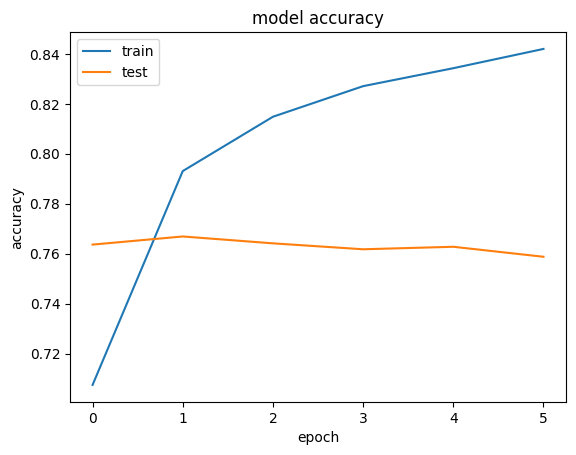

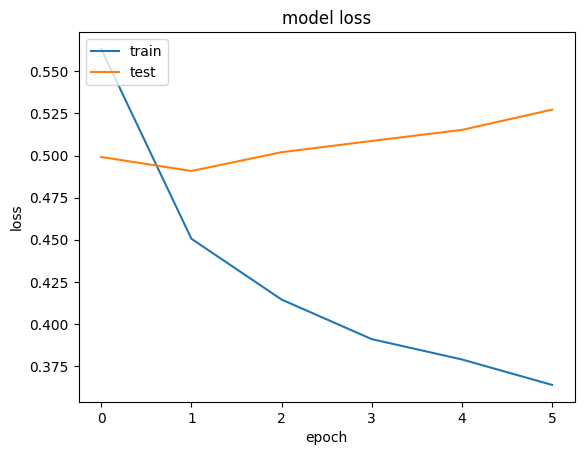

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)


#Adds a 1D convolutional layer with 128 filters, a kernel size of 5, and the ReLU activation function.
cnn_model.add(Conv1D(128, 5, activation='relu'))
#Parameters explained:
#128 filters: The number of output filters in the convolution.
#Kernel size of 5: The size of the convolution window.
#ReLU activation: Applies the ReLU activation function to the output of the convolution

cnn_model.add(GlobalMaxPooling1D()) #This layer performs global max pooling, which reduces the dimensionality by taking the maximum value over the time dimension for each feature map. This helps to reduce the output size and capture the most important features.
cnn_model.add(Dense(1, activation='sigmoid')) # Adds a fully connected layer with 1 neuron (output) and sigmoid activation function

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - acc: 0.6780 - loss: 0.6288 - val_acc: 0.8151 - val_loss: 0.4092
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - acc: 0.8484 - loss: 0.3567 - val_acc: 0.8416 - val_loss: 0.3572
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - acc: 0.8834 - loss: 0.2908 - val_acc: 0.8482 - val_loss: 0.3426
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - acc: 0.9103 - loss: 0.2455 - val_acc: 0.8490 - val_loss: 0.3388
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - acc: 0.9301 - loss: 0.2063 - val_acc: 0.8568 - val_loss: 0.3310
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - acc: 0.9521 - loss: 0.1683 - val_acc: 0.8596 - val_loss: 0.3324


In [ ]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.8611 - loss: 0.3298
Test Score: 0.33256497979164124
Test Accuracy: 0.8586000204086304


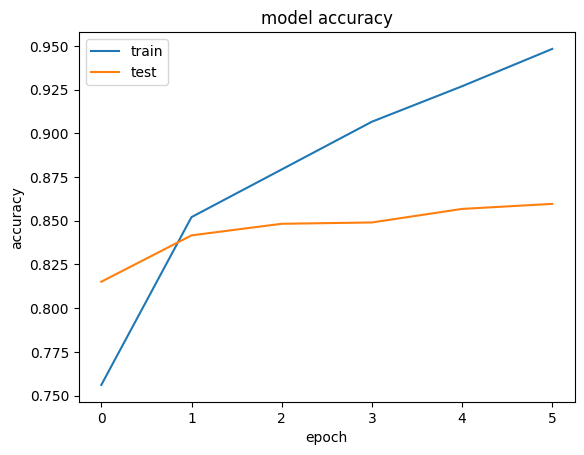

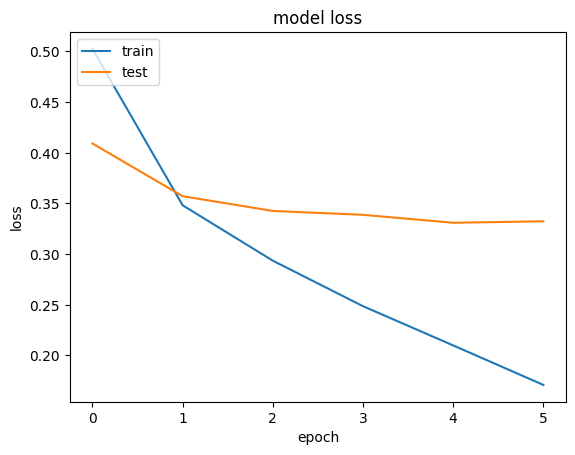

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)


In [ ]:
from keras.layers import LSTM

In [ ]:
# RNN architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))) #Adds a bidirectional LSTM layer with 128 units.
#Parameters explained:
#Bidirectional: Wraps the LSTM layer to process the input in both forward and backward directions.
#128 units: The number of LSTM units.
#dropout=0.2: Dropout rate for the input connections.
#recurrent_dropout=0.2: Dropout rate for the recurrent connections.
#kernel_regularizer=l2(0.01): L2 regularization to prevent overfitting.

lstm_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) #Adds a fully connected layer with 64 neurons.
#64 neurons: The number of neurons in the dense layer.
#activation='relu': Uses the ReLU activation function.
#kernel_regularizer=l2(0.01): L2 regularization to prevent overfitting.

lstm_model.add(Dropout(0.2)) # Adds a dropout layer with a dropout rate of 0.2 to prevent overfitting.
lstm_model.add(Dense(1, activation='sigmoid')) #Adds a fully connected layer with 1 neuron and a sigmoid activation function for binary classification.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 209ms/step - acc: 0.6457 - loss: 2.2090 - val_acc: 0.6996 - val_loss: 0.6727
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - acc: 0.6718 - loss: 0.6933 - val_acc: 0.5000 - val_loss: 0.7713
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 206ms/step - acc: 0.5496 - loss: 0.7462 - val_acc: 0.7329 - val_loss: 0.6069
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 224ms/step - acc: 0.6997 - loss: 0.6472 - val_acc: 0.7669 - val_loss: 0.5822
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 209ms/step - acc: 0.7465 - loss: 0.5943 - val_acc: 0.8059 - val_loss: 0.4965
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 201ms/step - acc: 0.7840 - loss: 0.5290 - val_acc: 0.8140 - val_loss: 0.4752


In [ ]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - acc: 0.8087 - loss: 0.4800
Test Score: 0.4818001389503479
Test Accuracy: 0.8073999881744385


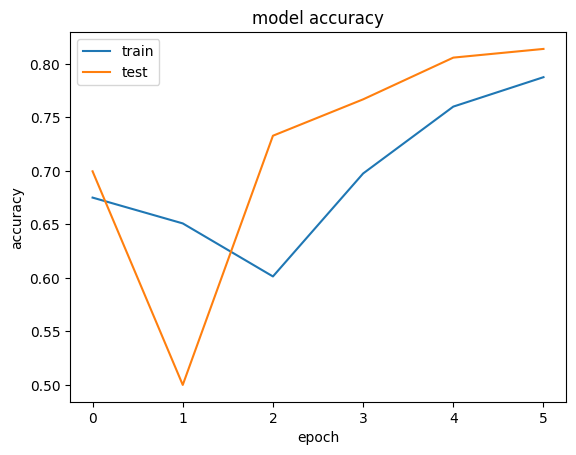

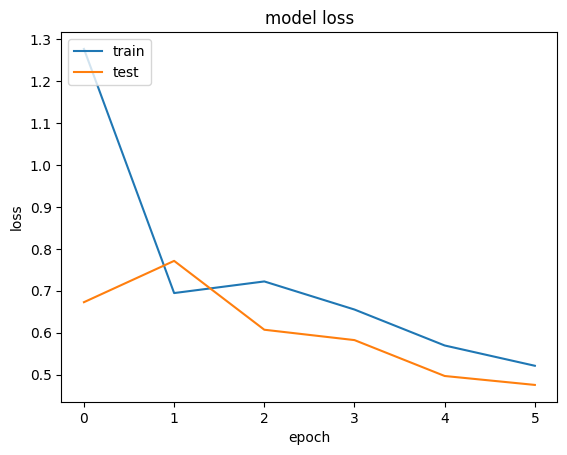

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later (Creating models from scratch requires lots of time and resources!)

lstm_model.save(f"./lstm_model_acc_{round(score[1], 3)}.keras")